In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import gensim

from gensim.models import Word2Vec, KeyedVectors

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
import nltk

from tensorflow.keras.utils import to_categorical

In [20]:
data = pd.read_csv("data/news_class.csv")

df = data.copy() # to be safe and avoid errors

df = df.loc[:,["data_id" , "content" , "category_level_1" , "category_level_2"]]
df.groupby(['category_level_1'])['data_id'].agg('count')

category_level_1
arts, culture, entertainment and media        300
conflict, war and peace                       800
crime, law and justice                        500
disaster, accident and emergency incident     500
economy, business and finance                 400
education                                     607
environment                                   600
health                                        700
human interest                                600
labour                                        703
lifestyle and leisure                         300
politics                                      900
religion and belief                           800
science and technology                        800
society                                      1100
sport                                         907
weather                                       400
Name: data_id, dtype: int64

In [3]:
def labeler(dataframe_column):
    encoder=LabelEncoder()
    
    labels = encoder.fit_transform(dataframe_column)
    print(encoder.classes_)
    print("We did it boys , labels have been created")
    
    return(pd.DataFrame(labels))

In [5]:
extra_stop = ['said', 'would','even','according','could','year','years','also','new','people','old,''one','two','time','first','last','say','make','best','get','three','make','year old','told','made','like','take','many','set','number','month','week','well','back' , 'post', 'http', 'www', 'presstv' , 'ir' , 'http' 'ta' 'com']
total_stop = stopwords.words("english") + extra_stop

In [19]:
# Function for removing ASCII characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting to lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words

def remove_stop_words(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text =  tokenizer.tokenize(text)
    stops = total_stop
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text


# Function for removing html
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

def lemm_text(text):
    lemm=WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    tokens = text
    return ' '.join([lemm.lemmatize(t) for t in tokens])


def remove_digits(text):
    text = re.sub(r'\d', '', text)
    #text = " ".join(text)
    return text

In [21]:
df['Cleaned'] = df['content'].apply(_removeNonAscii)
df['Cleaned'] = df.Cleaned.apply(func = make_lower_case)
df['Cleaned'] = df.Cleaned.apply(func = remove_stop_words)
df['Cleaned'] = df.Cleaned.apply(func = remove_punctuation)
df['Cleaned'] = df.Cleaned.apply(func = remove_html)
df['Cleaned'] = df.Cleaned.apply(func = lemm_text)
df['Cleaned'] = df.Cleaned.apply(func = remove_digits)
df = df.drop('content' , axis =1)

In [22]:
io = df.copy()

io = io.drop([374]).reset_index(drop=True)
io = io.drop([6527]).reset_index(drop=True)

corpus_full = []
for words in io['Cleaned']:
    corpus_full.append(words.split())  

In [23]:
io.tail()

,data_id,category_level_1,category_level_2,Cleaned
10910,907640,"conflict, war and peace",post-war reconstruction,originally published site beirut lebanon dep...
10911,892720,"conflict, war and peace",post-war reconstruction,originally published site kiev october ta dav...
10912,870499,"conflict, war and peace",post-war reconstruction,detail iran support iraq reconstruction en...
10913,887334,"conflict, war and peace",post-war reconstruction,detail iraq salih terrorism originally pub...
10914,885988,"conflict, war and peace",post-war reconstruction,http ta com politics originally published sit...


In [24]:
def vectorizer():
    
    
    # Creating a list for storing the vectors ('Description' into vectors)
    #global word_embeddings
    word_embeddings = []
    i = 0
    # Reading the each 'Description'
    for line in io['Cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in model.wv.key_to_index:
                count += 1
                if avgword2vec is None:
                    avgword2vec = model.wv[word]
                else:
                    avgword2vec = avgword2vec + model.wv[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            word_embeddings.append(avgword2vec)
        else:
            print("I found it , the error occurs at line:" , i)
          
        i +=1 

    return(pd.DataFrame(word_embeddings))  # Returning our Data as a Dataframe (aesthetic reasons)

In [25]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [26]:
#model = Word2Vec.load("word2vec.model3")


model = Word2Vec(sentences=corpus_full, vector_size=200, window=4, min_count=2, sg = 1 , hs = 1)  # skipgram architecture

model.save("model_no_numbers.h3")

In [27]:
vect = vectorizer()

In [31]:
y1 = labeler(io["category_level_1"])


X = vect.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2,random_state=42)

y_train1 = to_categorical(y_train)


['arts, culture, entertainment and media' 'conflict, war and peace'
 'crime, law and justice' 'disaster, accident and emergency incident'
 'economy, business and finance' 'education' 'environment' 'health'
 'human interest' 'labour' 'lifestyle and leisure' 'politics'
 'religion and belief' 'science and technology' 'society' 'sport'
 'weather']
We did it boys , labels have been created


In [32]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten , Input , Conv2D , MaxPooling2D , BatchNormalization

In [68]:
model6 = Sequential()
model6.add(Dense(100,input_dim=200,activation = "leaky_relu"))
model6.add(Dense(180,activation = "leaky_relu"))
model6.add(tf.keras.layers.Dropout(0.2))
model6.add(Dense(60,activation = "leaky_relu"))
#model6.add(Dense(30,activation = "leaky_relu"))
model6.add(Dense(17,activation = "softmax"))

In [69]:
opt = tf.keras.optimizers.AdamW(learning_rate =0.005 , beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.99)

In [70]:
model6.compile(optimizer = opt , 
              loss = 'categorical_crossentropy' ,
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

In [36]:
model6.fit(X_train , y_train1 , batch_size = 16 , epochs = 1 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(model6.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))


69/69 [==============================] - 0s 1ms/step
[14  1 16 ... 11  9 12]
              precision    recall  f1-score   support

           0       0.88      0.10      0.18        68
           1       0.71      0.66      0.69       176
           2       0.66      0.73      0.70        97
           3       0.69      0.64      0.67        90
           4       0.80      0.46      0.59        93
           5       0.57      0.78      0.66       108
           6       0.72      0.80      0.76       126
           7       0.67      0.72      0.70       136
           8       0.55      0.46      0.50       122
           9       0.77      0.55      0.64       155
          10       0.57      0.61      0.59        61
          11       0.46      0.59      0.52       172
          12       0.60      0.81      0.69       182
          13       0.64      0.56      0.59       151
          14       0.45      0.41      0.43       200
          15       0.75      0.84      0.79       169
   

In [37]:
for i in range(100):
    
    print( "At iteration "  ,i+2 , " we get these data :" )
    
    model6.fit(X_train , y_train1 , batch_size = 16 , epochs = 1 , validation_split=(0.2) ,verbose =1)

    predictions = np.argmax(model6.predict(X_test), axis=-1)

    print(classification_report(y_test.values , predictions))

At iteration  2  we get these data :
69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.52      0.44      0.48        68
           1       0.73      0.74      0.74       176
           2       0.71      0.77      0.74        97
           3       0.75      0.66      0.70        90
           4       0.70      0.49      0.58        93
           5       0.64      0.74      0.69       108
           6       0.75      0.83      0.78       126
           7       0.71      0.74      0.72       136
           8       0.67      0.51      0.58       122
           9       0.75      0.61      0.67       155
          10       0.62      0.61      0.61        61
          11       0.57      0.56      0.57       172
          12       0.66      0.79      0.72       182
          13       0.59      0.59      0.59       151
          14       0.53      0.51      0.52       200
          15       0.75      0.85      0.80  

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        68
           1       0.74      0.73      0.74       176
           2       0.74      0.72      0.73        97
           3       0.74      0.71      0.72        90
           4       0.76      0.52      0.62        93
           5       0.65      0.76      0.70       108
           6       0.82      0.87      0.84       126
           7       0.70      0.80      0.75       136
           8       0.70      0.44      0.54       122
           9       0.81      0.66      0.73       155
          10       0.66      0.66      0.66        61
          11       0.59      0.59      0.59       172
          12       0.68      0.78      0.72       182
          13       0.72      0.57      0.63       151
          14       0.51      0.62      0.56       200
          15       0.76      0.90      0.83       169
          16       0.83     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.75      0.53      0.62        68
           1       0.75      0.78      0.77       176
           2       0.76      0.68      0.72        97
           3       0.70      0.71      0.70        90
           4       0.75      0.53      0.62        93
           5       0.67      0.77      0.72       108
           6       0.82      0.83      0.82       126
           7       0.74      0.79      0.77       136
           8       0.71      0.52      0.60       122
           9       0.82      0.68      0.74       155
          10       0.74      0.69      0.71        61
          11       0.59      0.61      0.60       172
          12       0.71      0.82      0.76       182
          13       0.74      0.57      0.64       151
          14       0.52      0.68      0.59       200
          15       0.81      0.89      0.85       169
          16       0.84     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.80      0.51      0.62        68
           1       0.78      0.76      0.77       176
           2       0.74      0.71      0.73        97
           3       0.66      0.68      0.67        90
           4       0.73      0.56      0.63        93
           5       0.69      0.80      0.74       108
           6       0.85      0.84      0.85       126
           7       0.80      0.74      0.77       136
           8       0.69      0.66      0.67       122
           9       0.85      0.67      0.75       155
          10       0.72      0.75      0.74        61
          11       0.59      0.61      0.60       172
          12       0.76      0.79      0.77       182
          13       0.70      0.64      0.67       151
          14       0.56      0.70      0.62       200
          15       0.81      0.91      0.86       169
          16       0.80     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.61      0.56      0.58        68
           1       0.78      0.81      0.80       176
           2       0.77      0.74      0.76        97
           3       0.69      0.66      0.67        90
           4       0.74      0.58      0.65        93
           5       0.69      0.80      0.74       108
           6       0.81      0.86      0.83       126
           7       0.77      0.75      0.76       136
           8       0.74      0.57      0.65       122
           9       0.83      0.63      0.72       155
          10       0.71      0.69      0.70        61
          11       0.64      0.63      0.63       172
          12       0.73      0.79      0.76       182
          13       0.70      0.64      0.67       151
          14       0.54      0.67      0.60       200
          15       0.82      0.92      0.87       169
          16       0.84     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.79      0.49      0.60        68
           1       0.76      0.80      0.78       176
           2       0.77      0.74      0.75        97
           3       0.66      0.63      0.65        90
           4       0.79      0.58      0.67        93
           5       0.70      0.80      0.74       108
           6       0.84      0.83      0.83       126
           7       0.74      0.72      0.73       136
           8       0.62      0.65      0.63       122
           9       0.80      0.68      0.73       155
          10       0.77      0.66      0.71        61
          11       0.63      0.65      0.64       172
          12       0.75      0.76      0.76       182
          13       0.72      0.62      0.67       151
          14       0.54      0.66      0.59       200
          15       0.81      0.92      0.86       169
          16       0.79     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        68
           1       0.76      0.79      0.77       176
           2       0.77      0.75      0.76        97
           3       0.71      0.62      0.66        90
           4       0.72      0.58      0.64        93
           5       0.70      0.78      0.74       108
           6       0.82      0.85      0.84       126
           7       0.76      0.71      0.73       136
           8       0.70      0.60      0.65       122
           9       0.81      0.65      0.72       155
          10       0.73      0.72      0.73        61
          11       0.63      0.62      0.63       172
          12       0.74      0.79      0.76       182
          13       0.65      0.65      0.65       151
          14       0.55      0.65      0.60       200
          15       0.82      0.92      0.87       169
          16       0.81     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        68
           1       0.79      0.80      0.80       176
           2       0.79      0.73      0.76        97
           3       0.66      0.70      0.68        90
           4       0.78      0.54      0.64        93
           5       0.67      0.79      0.72       108
           6       0.83      0.83      0.83       126
           7       0.76      0.79      0.77       136
           8       0.73      0.63      0.68       122
           9       0.84      0.70      0.76       155
          10       0.77      0.75      0.76        61
          11       0.62      0.65      0.63       172
          12       0.76      0.75      0.75       182
          13       0.70      0.64      0.67       151
          14       0.54      0.63      0.58       200
          15       0.85      0.92      0.88       169
          16       0.81     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        68
           1       0.78      0.80      0.79       176
           2       0.73      0.74      0.74        97
           3       0.71      0.62      0.66        90
           4       0.75      0.58      0.65        93
           5       0.73      0.81      0.77       108
           6       0.83      0.84      0.84       126
           7       0.78      0.75      0.77       136
           8       0.70      0.63      0.66       122
           9       0.81      0.65      0.72       155
          10       0.77      0.72      0.75        61
          11       0.62      0.62      0.62       172
          12       0.76      0.81      0.78       182
          13       0.68      0.68      0.68       151
          14       0.56      0.64      0.60       200
          15       0.84      0.92      0.88       169
          16       0.83     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.69      0.62      0.65        68
           1       0.79      0.80      0.79       176
           2       0.78      0.73      0.76        97
           3       0.75      0.68      0.71        90
           4       0.78      0.60      0.68        93
           5       0.70      0.81      0.75       108
           6       0.84      0.85      0.84       126
           7       0.75      0.74      0.75       136
           8       0.74      0.53      0.62       122
           9       0.80      0.72      0.76       155
          10       0.69      0.77      0.73        61
          11       0.62      0.66      0.64       172
          12       0.77      0.81      0.79       182
          13       0.70      0.65      0.67       151
          14       0.53      0.67      0.59       200
          15       0.88      0.90      0.89       169
          16       0.87     

69/69 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        68
           1       0.80      0.80      0.80       176
           2       0.75      0.73      0.74        97
           3       0.69      0.66      0.67        90
           4       0.78      0.57      0.66        93
           5       0.67      0.81      0.73       108
           6       0.84      0.82      0.83       126
           7       0.76      0.76      0.76       136
           8       0.75      0.62      0.68       122
           9       0.81      0.68      0.74       155
          10       0.84      0.70      0.77        61
          11       0.65      0.63      0.64       172
          12       0.70      0.79      0.74       182
          13       0.69      0.64      0.66       151
          14       0.55      0.64      0.59       200
          15       0.84      0.93      0.88       169
          16       0.82     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.68      0.62      0.65        68
           1       0.80      0.82      0.81       176
           2       0.77      0.74      0.75        97
           3       0.66      0.68      0.67        90
           4       0.76      0.55      0.64        93
           5       0.65      0.81      0.72       108
           6       0.85      0.79      0.81       126
           7       0.75      0.73      0.74       136
           8       0.70      0.66      0.68       122
           9       0.82      0.61      0.70       155
          10       0.83      0.72      0.77        61
          11       0.63      0.62      0.63       172
          12       0.73      0.79      0.76       182
          13       0.69      0.64      0.66       151
          14       0.55      0.67      0.61       200
          15       0.84      0.93      0.88       169
          16       0.84     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        68
           1       0.79      0.81      0.80       176
           2       0.76      0.75      0.76        97
           3       0.71      0.64      0.67        90
           4       0.78      0.58      0.67        93
           5       0.70      0.83      0.76       108
           6       0.83      0.83      0.83       126
           7       0.80      0.75      0.77       136
           8       0.70      0.70      0.70       122
           9       0.80      0.70      0.75       155
          10       0.73      0.75      0.74        61
          11       0.63      0.60      0.62       172
          12       0.74      0.80      0.77       182
          13       0.71      0.66      0.68       151
          14       0.57      0.63      0.60       200
          15       0.87      0.92      0.89       169
          16       0.82     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.76      0.57      0.66        68
           1       0.80      0.80      0.80       176
           2       0.73      0.74      0.73        97
           3       0.71      0.68      0.69        90
           4       0.72      0.59      0.65        93
           5       0.68      0.81      0.74       108
           6       0.86      0.79      0.82       126
           7       0.76      0.76      0.76       136
           8       0.68      0.66      0.67       122
           9       0.80      0.68      0.74       155
          10       0.78      0.75      0.77        61
          11       0.62      0.63      0.63       172
          12       0.74      0.79      0.76       182
          13       0.67      0.66      0.67       151
          14       0.57      0.62      0.60       200
          15       0.87      0.93      0.90       169
          16       0.83     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.71      0.57      0.63        68
           1       0.78      0.83      0.81       176
           2       0.74      0.80      0.77        97
           3       0.71      0.61      0.65        90
           4       0.73      0.57      0.64        93
           5       0.71      0.78      0.74       108
           6       0.85      0.83      0.84       126
           7       0.78      0.73      0.75       136
           8       0.74      0.64      0.69       122
           9       0.79      0.65      0.71       155
          10       0.75      0.75      0.75        61
          11       0.61      0.59      0.60       172
          12       0.70      0.78      0.74       182
          13       0.65      0.66      0.66       151
          14       0.54      0.61      0.58       200
          15       0.84      0.92      0.88       169
          16       0.81     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.69      0.66      0.68        68
           1       0.82      0.78      0.80       176
           2       0.73      0.75      0.74        97
           3       0.69      0.67      0.68        90
           4       0.72      0.59      0.65        93
           5       0.71      0.81      0.75       108
           6       0.85      0.81      0.83       126
           7       0.76      0.73      0.74       136
           8       0.71      0.63      0.67       122
           9       0.84      0.74      0.79       155
          10       0.84      0.70      0.77        61
          11       0.62      0.59      0.61       172
          12       0.73      0.75      0.74       182
          13       0.68      0.65      0.66       151
          14       0.53      0.65      0.58       200
          15       0.85      0.93      0.89       169
          16       0.82     

69/69 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.78      0.66      0.71        68
           1       0.82      0.77      0.79       176
           2       0.73      0.78      0.76        97
           3       0.68      0.68      0.68        90
           4       0.72      0.56      0.63        93
           5       0.68      0.81      0.74       108
           6       0.85      0.79      0.82       126
           7       0.75      0.74      0.75       136
           8       0.75      0.66      0.70       122
           9       0.79      0.72      0.75       155
          10       0.79      0.75      0.77        61
          11       0.62      0.61      0.62       172
          12       0.70      0.77      0.73       182
          13       0.69      0.68      0.68       151
          14       0.58      0.64      0.61       200
          15       0.88      0.93      0.90       169
          16       0.82     

In [42]:
historu = model6.fit(X_train , y_train1 , batch_size = 16 , epochs = 94 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(model6.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))

Epoch 1/94
437/437 [==============================] - 3s 3ms/step - loss: 1.6200 - accuracy: 0.9513 - precision: 0.6978 - recall: 0.3038 - val_loss: 1.3321 - val_accuracy: 0.9558 - val_precision: 0.7390 - val_recall: 0.3841
Epoch 2/94
437/437 [==============================] - 1s 3ms/step - loss: 1.2934 - accuracy: 0.9576 - precision: 0.7269 - recall: 0.4484 - val_loss: 1.3125 - val_accuracy: 0.9581 - val_precision: 0.7314 - val_recall: 0.4551
Epoch 3/94
437/437 [==============================] - 1s 3ms/step - loss: 1.1941 - accuracy: 0.9603 - precision: 0.7447 - recall: 0.4953 - val_loss: 1.1931 - val_accuracy: 0.9604 - val_precision: 0.7379 - val_recall: 0.5060
Epoch 4/94
437/437 [==============================] - 1s 3ms/step - loss: 1.1408 - accuracy: 0.9612 - precision: 0.7423 - recall: 0.5224 - val_loss: 1.1797 - val_accuracy: 0.9620 - val_precision: 0.7445 - val_recall: 0.5386
Epoch 5/94
437/437 [==============================] - 1s 3ms/step - loss: 1.1121 - accuracy: 0.9623 - pr

437/437 [==============================] - 1s 2ms/step - loss: 0.6655 - accuracy: 0.9767 - precision: 0.8415 - recall: 0.7439 - val_loss: 1.5014 - val_accuracy: 0.9665 - val_precision: 0.7475 - val_recall: 0.6508
Epoch 74/94
437/437 [==============================] - 1s 2ms/step - loss: 0.6388 - accuracy: 0.9772 - precision: 0.8491 - recall: 0.7453 - val_loss: 1.6208 - val_accuracy: 0.9627 - val_precision: 0.7053 - val_recall: 0.6274
Epoch 75/94
437/437 [==============================] - 1s 2ms/step - loss: 0.6515 - accuracy: 0.9768 - precision: 0.8434 - recall: 0.7433 - val_loss: 1.5861 - val_accuracy: 0.9641 - val_precision: 0.7249 - val_recall: 0.6274
Epoch 76/94
437/437 [==============================] - 1s 2ms/step - loss: 0.6054 - accuracy: 0.9780 - precision: 0.8501 - recall: 0.7602 - val_loss: 1.5272 - val_accuracy: 0.9635 - val_precision: 0.7275 - val_recall: 0.6068
Epoch 77/94
437/437 [==============================] - 1s 2ms/step - loss: 0.6220 - accuracy: 0.9779 - precision

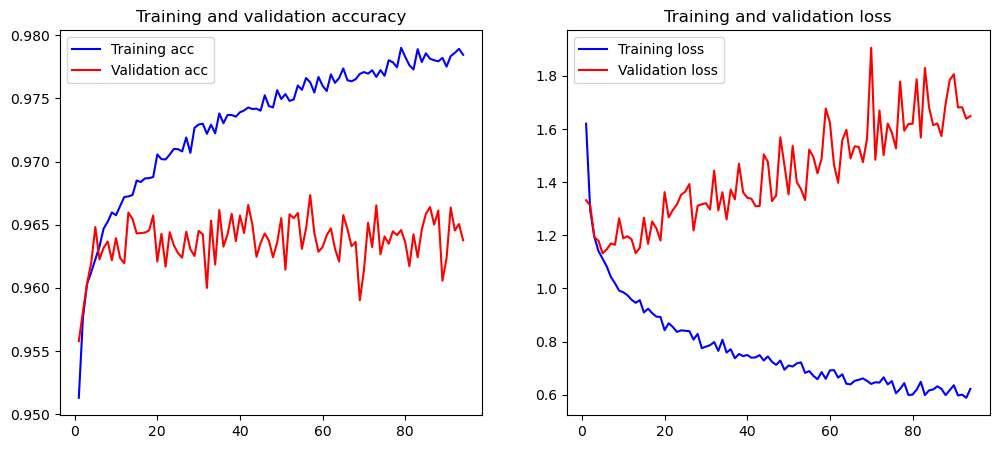

In [43]:
plot_history(historu)

Epoch 1/20
437/437 [==============================] - 3s 3ms/step - loss: 1.5905 - accuracy: 0.9524 - precision: 0.7165 - recall: 0.3165 - val_loss: 1.3918 - val_accuracy: 0.9575 - val_precision: 0.7221 - val_recall: 0.4522
Epoch 2/20
437/437 [==============================] - 1s 2ms/step - loss: 1.2508 - accuracy: 0.9588 - precision: 0.7375 - recall: 0.4649 - val_loss: 1.3141 - val_accuracy: 0.9593 - val_precision: 0.7345 - val_recall: 0.4814
Epoch 3/20
437/437 [==============================] - 1s 3ms/step - loss: 1.1310 - accuracy: 0.9615 - precision: 0.7520 - recall: 0.5157 - val_loss: 1.2244 - val_accuracy: 0.9606 - val_precision: 0.7288 - val_recall: 0.5260
Epoch 4/20
437/437 [==============================] - 1s 3ms/step - loss: 1.0930 - accuracy: 0.9624 - precision: 0.7545 - recall: 0.5356 - val_loss: 1.3092 - val_accuracy: 0.9603 - val_precision: 0.7263 - val_recall: 0.5226
Epoch 5/20
437/437 [==============================] - 1s 3ms/step - loss: 1.0496 - accuracy: 0.9643 - pr

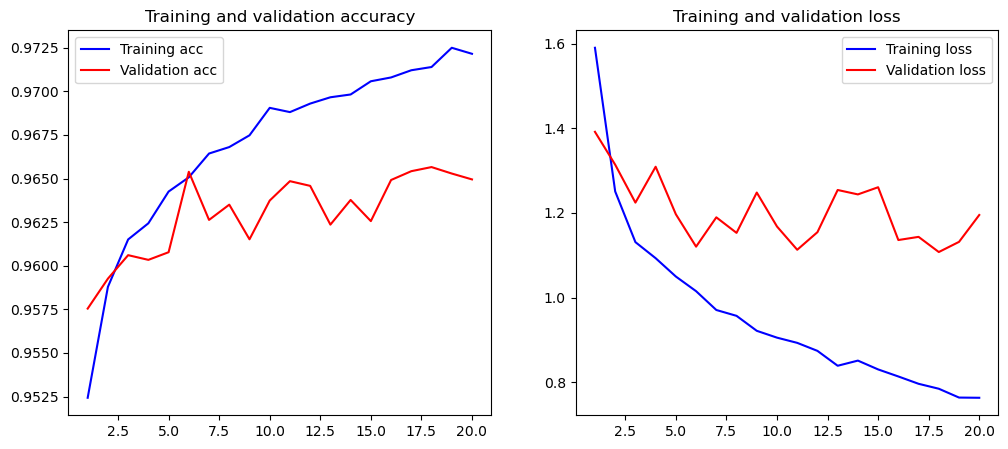

In [71]:
historu2 = model6.fit(X_train , y_train1 , batch_size = 16 , epochs = 20 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(model6.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))

plot_history(historu2)

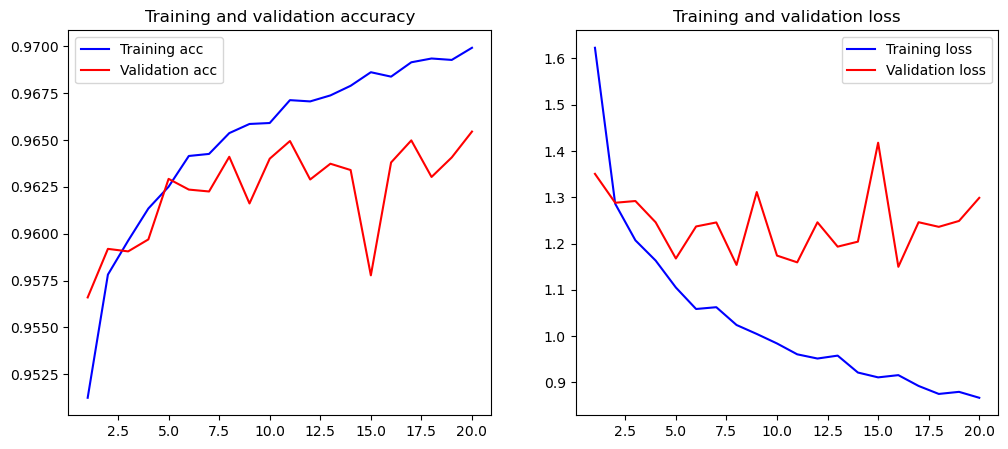

In [50]:
plot_history(historu2)

In [65]:
historu3 = model6.fit(X_train , y_train1 , batch_size = 16 , epochs = 10 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(model6.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))

Epoch 1/10
437/437 [==============================] - 2s 3ms/step - loss: 1.5720 - accuracy: 0.9521 - precision: 0.7091 - recall: 0.3148 - val_loss: 1.2997 - val_accuracy: 0.9584 - val_precision: 0.7642 - val_recall: 0.4230
Epoch 2/10
437/437 [==============================] - 1s 2ms/step - loss: 1.2447 - accuracy: 0.9578 - precision: 0.7258 - recall: 0.4537 - val_loss: 1.2005 - val_accuracy: 0.9612 - val_precision: 0.7513 - val_recall: 0.5083
Epoch 3/10
437/437 [==============================] - 1s 2ms/step - loss: 1.1449 - accuracy: 0.9616 - precision: 0.7521 - recall: 0.5181 - val_loss: 1.2184 - val_accuracy: 0.9617 - val_precision: 0.7442 - val_recall: 0.5329
Epoch 4/10
437/437 [==============================] - 1s 2ms/step - loss: 1.0851 - accuracy: 0.9632 - precision: 0.7596 - recall: 0.5470 - val_loss: 1.2147 - val_accuracy: 0.9621 - val_precision: 0.7449 - val_recall: 0.5415
Epoch 5/10
437/437 [==============================] - 1s 3ms/step - loss: 1.0572 - accuracy: 0.9638 - pr

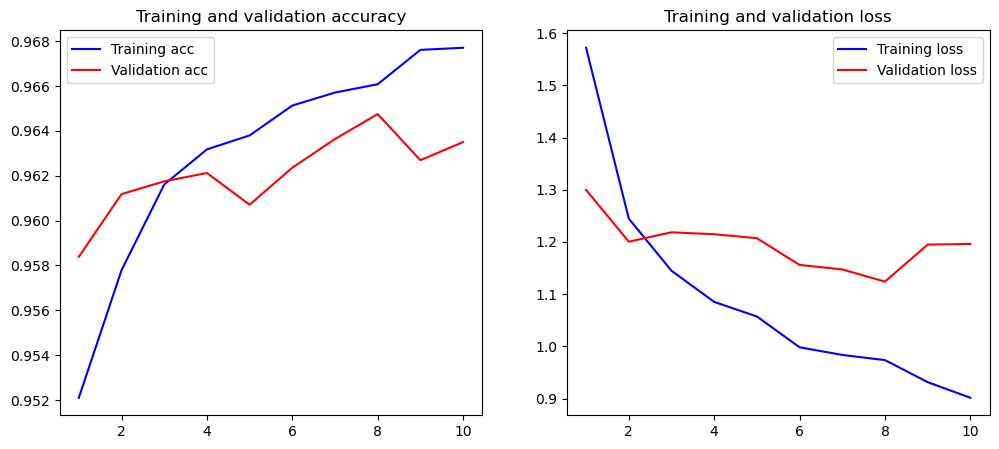

In [66]:
plot_history(historu3)